In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 11.2 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=3129221d187fc499e63b0f2f9ceb06934fd5940b3e0e0f473f96b3e1b6b50b7b
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [9]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from transformers import T5Model, T5TokenizerFast
import networkx as nx
from torch_geometric.data import Data
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch_geometric.data import Batch
from transformers import T5Model
from torch_geometric.nn import GCNConv
from datasets import load_dataset
from torch_geometric.data import Data
from transformers import T5TokenizerFast
import networkx as nx
import torch
import re
import matplotlib.pyplot as plt

#model_name = "t5-small"
model_name = "google/flan-t5-small"


class WebNLGDataset(Dataset):
    def __init__(self, dataset, max_edges=512):
        self.dataset = dataset
        self.max_edges = max_edges
        self.prefix = "translate graph to text:"
        
        # Initiate the tokenizer
        self.tokenizer = T5TokenizerFast.from_pretrained(model_name)
        self.node_to_idx = {}  # Node to index mapping

        # Add special tokens
        new_tokens = ['<H>', '<R>', '<T>']
        new_tokens_vocab = {'additional_special_tokens': new_tokens}
        self.tokenizer.add_special_tokens(new_tokens_vocab)


    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data_dict = self.dataset[idx]
        
        triples = data_dict['original_triple_sets']['otriple_set'][0]
        target_text = data_dict['lex']['text'][0]

        # linearize the triples
        input_text = self.prefix
        for triple in triples:
            triple_txt = triple.split("|")
            input_text += " <H> " + triple_txt[0] + " <R> " + triple_txt[1] + " <T> " + triple_txt[2]
        
        # graph creation
        graph_nx = self.triples_to_graph(triples)
        edge_index = self.get_edge_index(graph_nx)

        # encoding input and target texts
        input_encoding = self.tokenizer.encode_plus(input_text, truncation=True, padding='max_length', max_length=512, return_tensors='pt')
        target_encoding = self.tokenizer.encode_plus(target_text, truncation=True, padding='max_length', max_length=512, return_tensors='pt')
        
        graph_data = Data(x=input_encoding['input_ids'].squeeze(dim=0), edge_index=edge_index)
        graph_data.attention_mask = input_encoding['attention_mask'].squeeze(dim=0)
        graph_data.y = target_encoding['input_ids'].squeeze(dim=0)
    
        '''print("Original Sample: \n", input_text, "\n", target_text)  # Print the original and target samples      
        print("NetworkX Graph: \n", graph_nx.edges) # Print the NetworkX graph
        self.visualize_graph(graph_nx)
        print("Decoded Input: \n", self.tokenizer.decode(graph_data.x, skip_special_tokens=True))
        print("Decoded Target: \n", self.tokenizer.decode(graph_data.y, skip_special_tokens=True))'''

        return graph_data

    def triples_to_graph(self, triples):
        self.node_to_idx = {}  # reset for each new graph
        graph_nx = nx.MultiDiGraph()
        for triple in triples:
            triple = re.sub(r'\([^)]*\)', '', triple).split('|')  # remove brackets and split by '|'
            subject, relation, obj = map(str.strip, triple)

            # Add string node names to the graph
            if subject not in self.node_to_idx:
                self.node_to_idx[subject] = len(self.node_to_idx)
            if obj not in self.node_to_idx:
                self.node_to_idx[obj] = len(self.node_to_idx)

            graph_nx.add_edge(subject, obj, key=relation)
        return graph_nx

    def get_edge_index(self, graph_nx):
        edge_index = torch.tensor([[self.node_to_idx[n] for n in edge[:2]] for edge in graph_nx.edges]).t().contiguous()
        return edge_index
    
    def visualize_graph(self, graph_nx):
        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(graph_nx)  # positions for all nodes
        nx.draw(graph_nx, pos, with_labels=True)
        labels = nx.get_edge_attributes(graph_nx, 'key')
        nx.draw_networkx_edge_labels(graph_nx, pos, edge_labels=labels)
        plt.show()

    
class AdapterBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AdapterBlock, self).__init__()
        self.layer_norm = nn.LayerNorm(input_dim, eps=1e-6)
        self.gcn = GCNConv(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_dim, input_dim)  # Restore dimension to input_dim
        self.res_fc = nn.Linear(input_dim, input_dim)  # Transform the residual

    def forward(self, x, edge_index):
        x_res = self.res_fc(x)  # Transform the residual tensor
        x = self.layer_norm(x)
        x = self.gcn(x, edge_index)
        x = self.relu(x)
        x = self.fc(x)
        return x + x_res  # Now you can add the tensors


from transformers import T5ForConditionalGeneration

class TransformerGCN(nn.Module):
    def __init__(self, vocab_size, adapter_dim):
        super(TransformerGCN, self).__init__()
        self.transformer = T5ForConditionalGeneration.from_pretrained(model_name)
        self.hidden_size = self.transformer.config.hidden_size
        #print('hidden size ', self.hidden_size)
        #self.reduce_dim = nn.Linear(32128, adapter_dim)

        # Freeze the parameters of the T5 model
        for param in self.transformer.parameters():
            param.requires_grad = False

        self.adapter_blocks = nn.ModuleList([
        AdapterBlock(block.layer[1].DenseReluDense.wo.weight.size(0), adapter_dim) for block in self.transformer.encoder.block
        ])

        self.output_head = nn.Linear(adapter_dim, vocab_size)

    def forward(self, input_ids, attention_mask, edge_index):
        if input_ids.dim() == 1:  # If the input is 1D (batch size 1)
            #print('unsqueeze input_ids')
            input_ids = input_ids.unsqueeze(0)  # Add a batch dimension
        if attention_mask.dim() == 1:  # Same for the attention_mask
            #print('unsqueeze attention_mask')
            attention_mask = attention_mask.unsqueeze(0)

        #print(f"Input_ids shape: {input_ids.shape}")  # Check input_ids shape
        #print(f"Attention_mask shape: {attention_mask.shape}")  # Check attention_mask shape

        shifted_input_ids = torch.cat([torch.zeros((input_ids.size(0), 1), dtype=torch.long, device=input_ids.device), input_ids[:, :-1]], dim=-1)

        #print(f"Shifted_input_ids shape: {shifted_input_ids.shape}")  # Check shifted_input_ids shape

        input_embeds = self.transformer.get_input_embeddings()(input_ids)
        hidden_states = input_embeds

        for block, adapter_block in zip(self.transformer.encoder.block, self.adapter_blocks):
            hidden_states, _ = block(hidden_states, attention_mask=attention_mask, encoder_hidden_states=None, encoder_attention_mask=None)
            hidden_states = adapter_block(hidden_states, edge_index)
        
        #print(f"Hidden_states shape: {hidden_states.shape}")  # Check hidden_states shape

        transformer_outputs = self.transformer(inputs_embeds=hidden_states, attention_mask=attention_mask, decoder_input_ids=shifted_input_ids)
        #print(f"Transformer_outputs shape (before reduction): {transformer_outputs[0].shape}")  # Check transformer_outputs shape before dimension reduction

        #transformer_outputs = self.reduce_dim(transformer_outputs[0])
        #print(f"Transformer_outputs shape (after reduction): {transformer_outputs.shape}")  # Check transformer_outputs shape after dimension reduction

        #return self.output_head(transformer_outputs)
        return transformer_outputs


class ModifiedT5Block(nn.Module):
    def __init__(self, original_block, adapter_dim):
        super(ModifiedT5Block, self).__init__()
        self.original_block = original_block
        self.adapter = AdapterBlock(original_block.layer[1].DenseReluDense.wi.weight.size(-1), adapter_dim)

    def forward(self, x, edge_index, **kwargs):
        x, _ = self.original_block(x, **kwargs)
        return self.adapter(x, edge_index)



from torch_geometric.data import DataLoader as GeometricDataLoader

def train(model, dataloader, epochs, device):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # Lower learning rate
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min') # Add learning rate scheduler
    tokenizer = T5TokenizerFast.from_pretrained(model_name)
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

    for epoch in range(epochs):
        model.train()
        i = 0
        for data in tqdm(dataloader):
            data = data.to(device) # Moving batch to device
            optimizer.zero_grad()

            outputs = model(input_ids=data.x, attention_mask=data.attention_mask, edge_index=data.edge_index)
            #loss = criterion(outputs.view(-1, outputs.size(-1)), data.y.view(-1))
            logits = outputs.logits  # Extract logits
            # Reshape the labels to match the logits
            labels = data.y.view(1, -1)  # The resulting shape is (1, 512)
            loss = criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Gradient clipping
            optimizer.step()
            
            #scheduler.step(loss) # Update learning rate
            
            if i % 100 == 0:
                print(f"Epoch: {epoch}, Iteration: {i}, Loss: {loss.item()}, Learning Rate: {optimizer.param_groups[0]['lr']}") 
            i += 1


# Usage
dataset_dict = load_dataset('web_nlg', 'webnlg_challenge_2017')['train']
dataset = WebNLGDataset(dataset_dict)
vocab_size = len(dataset.tokenizer)
model = TransformerGCN(vocab_size=vocab_size, adapter_dim=512)
dataloader = GeometricDataLoader(dataset, batch_size=1)
train(model, dataloader, epochs=1, device=torch.device('cuda'))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 2/6940 [00:00<10:43, 10.78it/s]

Epoch: 0, Iteration: 0, Loss: 8.285043716430664, Learning Rate: 0.0001


  1%|▏         | 102/6940 [00:09<10:23, 10.97it/s]

Epoch: 0, Iteration: 100, Loss: 8.37450122833252, Learning Rate: 1.0000000000000004e-08


  3%|▎         | 203/6940 [00:18<10:27, 10.74it/s]

Epoch: 0, Iteration: 200, Loss: 6.671534538269043, Learning Rate: 1.0000000000000004e-08


  4%|▍         | 301/6940 [00:27<09:59, 11.07it/s]

Epoch: 0, Iteration: 300, Loss: 6.654524326324463, Learning Rate: 1.0000000000000004e-08


  6%|▌         | 403/6940 [00:36<09:46, 11.14it/s]

Epoch: 0, Iteration: 400, Loss: 8.318092346191406, Learning Rate: 1.0000000000000004e-08


  7%|▋         | 502/6940 [00:46<09:41, 11.07it/s]

Epoch: 0, Iteration: 500, Loss: 7.685850620269775, Learning Rate: 1.0000000000000004e-08


  9%|▊         | 602/6940 [00:55<09:29, 11.12it/s]

Epoch: 0, Iteration: 600, Loss: 7.736546516418457, Learning Rate: 1.0000000000000004e-08


 10%|█         | 702/6940 [01:04<09:20, 11.13it/s]

Epoch: 0, Iteration: 700, Loss: 6.179423809051514, Learning Rate: 1.0000000000000004e-08


 12%|█▏        | 802/6940 [01:13<09:23, 10.89it/s]

Epoch: 0, Iteration: 800, Loss: 7.100235939025879, Learning Rate: 1.0000000000000004e-08


 13%|█▎        | 903/6940 [01:23<09:01, 11.15it/s]

Epoch: 0, Iteration: 900, Loss: 7.869883060455322, Learning Rate: 1.0000000000000004e-08


 14%|█▍        | 1003/6940 [01:32<08:55, 11.09it/s]

Epoch: 0, Iteration: 1000, Loss: 8.324145317077637, Learning Rate: 1.0000000000000004e-08


 16%|█▌        | 1103/6940 [01:41<08:47, 11.06it/s]

Epoch: 0, Iteration: 1100, Loss: 6.724234104156494, Learning Rate: 1.0000000000000004e-08


 17%|█▋        | 1202/6940 [01:50<08:31, 11.22it/s]

Epoch: 0, Iteration: 1200, Loss: 8.744004249572754, Learning Rate: 1.0000000000000004e-08


 19%|█▉        | 1302/6940 [01:59<08:26, 11.14it/s]

Epoch: 0, Iteration: 1300, Loss: 8.781488418579102, Learning Rate: 1.0000000000000004e-08


 20%|██        | 1402/6940 [02:08<08:39, 10.65it/s]

Epoch: 0, Iteration: 1400, Loss: 7.690706729888916, Learning Rate: 1.0000000000000004e-08


 22%|██▏       | 1502/6940 [02:18<13:08,  6.90it/s]

Epoch: 0, Iteration: 1500, Loss: 7.676519393920898, Learning Rate: 1.0000000000000004e-08


 23%|██▎       | 1602/6940 [02:27<07:56, 11.21it/s]

Epoch: 0, Iteration: 1600, Loss: 8.236757278442383, Learning Rate: 1.0000000000000004e-08


 25%|██▍       | 1702/6940 [02:36<07:52, 11.08it/s]

Epoch: 0, Iteration: 1700, Loss: 8.355745315551758, Learning Rate: 1.0000000000000004e-08


 26%|██▌       | 1802/6940 [02:45<07:54, 10.84it/s]

Epoch: 0, Iteration: 1800, Loss: 6.736067295074463, Learning Rate: 1.0000000000000004e-08


 27%|██▋       | 1902/6940 [02:54<07:34, 11.08it/s]

Epoch: 0, Iteration: 1900, Loss: 6.935805320739746, Learning Rate: 1.0000000000000004e-08


 29%|██▉       | 2002/6940 [03:04<07:24, 11.10it/s]

Epoch: 0, Iteration: 2000, Loss: 8.805642127990723, Learning Rate: 1.0000000000000004e-08


 30%|███       | 2102/6940 [03:13<07:17, 11.06it/s]

Epoch: 0, Iteration: 2100, Loss: 8.0216703414917, Learning Rate: 1.0000000000000004e-08


 32%|███▏      | 2202/6940 [03:22<07:16, 10.85it/s]

Epoch: 0, Iteration: 2200, Loss: 7.827295780181885, Learning Rate: 1.0000000000000004e-08


 33%|███▎      | 2302/6940 [03:31<06:58, 11.09it/s]

Epoch: 0, Iteration: 2300, Loss: 7.908083438873291, Learning Rate: 1.0000000000000004e-08


 35%|███▍      | 2402/6940 [03:40<06:47, 11.13it/s]

Epoch: 0, Iteration: 2400, Loss: 8.471826553344727, Learning Rate: 1.0000000000000004e-08


 36%|███▌      | 2502/6940 [03:50<06:43, 10.99it/s]

Epoch: 0, Iteration: 2500, Loss: 7.756912708282471, Learning Rate: 1.0000000000000004e-08


 37%|███▋      | 2602/6940 [03:59<06:33, 11.03it/s]

Epoch: 0, Iteration: 2600, Loss: 7.547399044036865, Learning Rate: 1.0000000000000004e-08


 39%|███▉      | 2702/6940 [04:08<06:30, 10.84it/s]

Epoch: 0, Iteration: 2700, Loss: 7.62590217590332, Learning Rate: 1.0000000000000004e-08


 40%|████      | 2802/6940 [04:17<06:17, 10.97it/s]

Epoch: 0, Iteration: 2800, Loss: 8.763280868530273, Learning Rate: 1.0000000000000004e-08


 42%|████▏     | 2903/6940 [04:27<06:03, 11.10it/s]

Epoch: 0, Iteration: 2900, Loss: 8.024765968322754, Learning Rate: 1.0000000000000004e-08


 43%|████▎     | 3003/6940 [04:36<05:55, 11.09it/s]

Epoch: 0, Iteration: 3000, Loss: 7.953181743621826, Learning Rate: 1.0000000000000004e-08


 45%|████▍     | 3103/6940 [04:45<05:52, 10.89it/s]

Epoch: 0, Iteration: 3100, Loss: 7.264688014984131, Learning Rate: 1.0000000000000004e-08


 46%|████▌     | 3201/6940 [04:54<05:41, 10.96it/s]

Epoch: 0, Iteration: 3200, Loss: 8.812507629394531, Learning Rate: 1.0000000000000004e-08


 48%|████▊     | 3302/6940 [05:04<05:30, 10.99it/s]

Epoch: 0, Iteration: 3300, Loss: 8.031641006469727, Learning Rate: 1.0000000000000004e-08


 49%|████▉     | 3402/6940 [05:13<05:21, 11.01it/s]

Epoch: 0, Iteration: 3400, Loss: 8.078232765197754, Learning Rate: 1.0000000000000004e-08


 50%|█████     | 3502/6940 [05:22<05:12, 11.01it/s]

Epoch: 0, Iteration: 3500, Loss: 8.684660911560059, Learning Rate: 1.0000000000000004e-08


 52%|█████▏    | 3603/6940 [05:32<05:05, 10.93it/s]

Epoch: 0, Iteration: 3600, Loss: 7.934624671936035, Learning Rate: 1.0000000000000004e-08


 53%|█████▎    | 3703/6940 [05:41<04:57, 10.88it/s]

Epoch: 0, Iteration: 3700, Loss: 8.08349609375, Learning Rate: 1.0000000000000004e-08


 55%|█████▍    | 3803/6940 [05:51<04:46, 10.94it/s]

Epoch: 0, Iteration: 3800, Loss: 7.7427592277526855, Learning Rate: 1.0000000000000004e-08


 56%|█████▌    | 3902/6940 [06:00<04:41, 10.77it/s]

Epoch: 0, Iteration: 3900, Loss: 7.384222984313965, Learning Rate: 1.0000000000000004e-08


 58%|█████▊    | 4002/6940 [06:09<04:29, 10.91it/s]

Epoch: 0, Iteration: 4000, Loss: 8.962018966674805, Learning Rate: 1.0000000000000004e-08


 59%|█████▉    | 4102/6940 [06:18<04:20, 10.89it/s]

Epoch: 0, Iteration: 4100, Loss: 8.89052677154541, Learning Rate: 1.0000000000000004e-08


 61%|██████    | 4202/6940 [06:28<04:27, 10.22it/s]

Epoch: 0, Iteration: 4200, Loss: 8.278626441955566, Learning Rate: 1.0000000000000004e-08


 62%|██████▏   | 4302/6940 [06:37<03:58, 11.06it/s]

Epoch: 0, Iteration: 4300, Loss: 8.465010643005371, Learning Rate: 1.0000000000000004e-08


 63%|██████▎   | 4402/6940 [06:46<03:51, 10.98it/s]

Epoch: 0, Iteration: 4400, Loss: 7.255240440368652, Learning Rate: 1.0000000000000004e-08


 65%|██████▍   | 4502/6940 [06:55<03:42, 10.94it/s]

Epoch: 0, Iteration: 4500, Loss: 7.507091045379639, Learning Rate: 1.0000000000000004e-08


 66%|██████▋   | 4602/6940 [07:05<03:31, 11.06it/s]

Epoch: 0, Iteration: 4600, Loss: 8.50223445892334, Learning Rate: 1.0000000000000004e-08


 68%|██████▊   | 4702/6940 [07:14<03:22, 11.04it/s]

Epoch: 0, Iteration: 4700, Loss: 8.019952774047852, Learning Rate: 1.0000000000000004e-08


 69%|██████▉   | 4802/6940 [07:23<03:12, 11.09it/s]

Epoch: 0, Iteration: 4800, Loss: 7.318449974060059, Learning Rate: 1.0000000000000004e-08


 71%|███████   | 4902/6940 [07:32<03:38,  9.32it/s]

Epoch: 0, Iteration: 4900, Loss: 7.54195499420166, Learning Rate: 1.0000000000000004e-08


 72%|███████▏  | 5002/6940 [07:42<02:57, 10.92it/s]

Epoch: 0, Iteration: 5000, Loss: 8.482916831970215, Learning Rate: 1.0000000000000004e-08


 74%|███████▎  | 5102/6940 [07:51<02:51, 10.74it/s]

Epoch: 0, Iteration: 5100, Loss: 6.985296249389648, Learning Rate: 1.0000000000000004e-08


 75%|███████▍  | 5202/6940 [08:00<02:37, 11.06it/s]

Epoch: 0, Iteration: 5200, Loss: 7.937525272369385, Learning Rate: 1.0000000000000004e-08


 76%|███████▋  | 5303/6940 [08:10<02:29, 10.99it/s]

Epoch: 0, Iteration: 5300, Loss: 9.351859092712402, Learning Rate: 1.0000000000000004e-08


 78%|███████▊  | 5403/6940 [08:19<02:21, 10.88it/s]

Epoch: 0, Iteration: 5400, Loss: 7.916662693023682, Learning Rate: 1.0000000000000004e-08


 79%|███████▉  | 5503/6940 [08:28<02:13, 10.74it/s]

Epoch: 0, Iteration: 5500, Loss: 8.076799392700195, Learning Rate: 1.0000000000000004e-08


 81%|████████  | 5602/6940 [08:37<02:27,  9.10it/s]

Epoch: 0, Iteration: 5600, Loss: 7.264306545257568, Learning Rate: 1.0000000000000004e-08


 82%|████████▏ | 5702/6940 [08:47<01:51, 11.10it/s]

Epoch: 0, Iteration: 5700, Loss: 6.640398979187012, Learning Rate: 1.0000000000000004e-08


 84%|████████▎ | 5802/6940 [08:56<01:42, 11.10it/s]

Epoch: 0, Iteration: 5800, Loss: 7.730413913726807, Learning Rate: 1.0000000000000004e-08


 85%|████████▌ | 5902/6940 [09:05<01:33, 11.09it/s]

Epoch: 0, Iteration: 5900, Loss: 7.774786949157715, Learning Rate: 1.0000000000000004e-08


 86%|████████▋ | 6003/6940 [09:14<01:24, 11.07it/s]

Epoch: 0, Iteration: 6000, Loss: 8.078764915466309, Learning Rate: 1.0000000000000004e-08


 88%|████████▊ | 6103/6940 [09:24<01:17, 10.86it/s]

Epoch: 0, Iteration: 6100, Loss: 7.202852725982666, Learning Rate: 1.0000000000000004e-08


 89%|████████▉ | 6203/6940 [09:33<01:06, 11.10it/s]

Epoch: 0, Iteration: 6200, Loss: 7.017477035522461, Learning Rate: 1.0000000000000004e-08


 91%|█████████ | 6302/6940 [09:42<00:58, 10.93it/s]

Epoch: 0, Iteration: 6300, Loss: 7.395164966583252, Learning Rate: 1.0000000000000004e-08


 92%|█████████▏| 6402/6940 [09:51<00:48, 11.00it/s]

Epoch: 0, Iteration: 6400, Loss: 8.780202865600586, Learning Rate: 1.0000000000000004e-08


 94%|█████████▎| 6502/6940 [10:00<00:39, 11.08it/s]

Epoch: 0, Iteration: 6500, Loss: 7.601197719573975, Learning Rate: 1.0000000000000004e-08


 95%|█████████▌| 6602/6940 [10:10<00:30, 10.99it/s]

Epoch: 0, Iteration: 6600, Loss: 7.761992454528809, Learning Rate: 1.0000000000000004e-08


 97%|█████████▋| 6702/6940 [10:19<00:21, 10.97it/s]

Epoch: 0, Iteration: 6700, Loss: 7.909750461578369, Learning Rate: 1.0000000000000004e-08


 98%|█████████▊| 6802/6940 [10:28<00:12, 10.80it/s]

Epoch: 0, Iteration: 6800, Loss: 8.331193923950195, Learning Rate: 1.0000000000000004e-08


 99%|█████████▉| 6902/6940 [10:37<00:03, 10.67it/s]

Epoch: 0, Iteration: 6900, Loss: 7.506100654602051, Learning Rate: 1.0000000000000004e-08


100%|██████████| 6940/6940 [10:41<00:00, 10.82it/s]


In [10]:
def test(model, dataloader, device):
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        for data in dataloader:
            data = data.to(device) 

            data.x = data.x.unsqueeze(0)  # Add batch dimension
            data.attention_mask = data.attention_mask.unsqueeze(0) 

            outputs = model.transformer.generate(input_ids=data.x, attention_mask=data.attention_mask, decoder_start_token_id=model.transformer.config.pad_token_id, max_length=100, num_beams=4, early_stopping=True)

            # Convert the tensor outputs to text using the tokenizer
            output_text = [dataset.tokenizer.decode(g, skip_special_tokens=False, clean_up_tokenization_spaces=False) for g in outputs]

            # print input and output
            print(f"Input: {dataset.tokenizer.decode(data.x[0].tolist(), skip_special_tokens=True)}")  # Convert tensor to list
            print(f"Output: {output_text}")

# Usage
dataset_dict = load_dataset('web_nlg', 'webnlg_challenge_2017')['test']
dataset_dict = [sample for sample in dataset_dict if sample['lex']['text']] # filter out samples with empty targets 
dataset = WebNLGDataset(dataset_dict)
dataloader = GeometricDataLoader(dataset, batch_size=1)
test(model, dataloader, device=torch.device('cuda'))


  0%|          | 0/3 [00:00<?, ?it/s]

Input: translate graph to text:  Aaron_S._Daggett  award  Purple_Heart
Output: ['<pad> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk></s>']
Input: translate graph to text:  Aaron_S._Daggett  battle  Battle_of_Mine_Run
Output: ['<pad> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk></s>']
Input: translate graph to text:  Ab_Klink  placeOfBirth  "Stellendam, Netherlands"@en
Output: ['<pad> <unk> Ab_Klink <unk> placeOfBirth <unk> "Stellendam, Netherlands"@en</s>']
Input: translate graph to text:  Abdul_Rahman_Ya'kub  governor  Tuanku_Bujang_Tuanku_Othman
Output: ['<pad> <unk> <unk> <unk> <unk> <unk> <unk> <unk></s>']
Input: translate graph to text:  Abdul_Taib_Mahmud  party  "Parti Bumiputera Sarawak"@en
Output: ['<pad> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk></s>']
Input: translate graph to text:  Abdul_Taib_Mahmud  successor  Sulaiman_Abdul_Rahman_Taib
Output: ['<pad> <unk> <unk> <unk> <unk> <unk> <unk> <unk></s>']
Input: translate graph to text:  Abdulsal

KeyboardInterrupt: 

In [5]:
!pip install sacrebleu 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 6.6 MB/s eta 0:00:00


In [24]:
from sacrebleu import corpus_bleu
from random import sample
from tqdm import tqdm
from torch_geometric.data import DataLoader as GeometricDataLoader

# load the WebNLG validation dataset
validation_dataset = load_dataset('web_nlg', 'webnlg_challenge_2017')['test']
validation_dataset = [sample for sample in validation_dataset if sample['lex']['text']]  # filter out samples with empty targets

validation_data = WebNLGDataset(validation_dataset)

# set up the validation data loader
validation_loader = GeometricDataLoader(validation_data, batch_size=1, shuffle=False)

# switch model to evaluation mode
model.eval()

device = 'cuda'

# generate predictions for the validation dataset
predictions = []
references = []
with torch.no_grad():
    for data in tqdm(validation_loader, desc='Validation Progress', leave=False):
        data.x = data.x.to(device).unsqueeze(0)  # add batch dimension
        data.attention_mask = data.attention_mask.to(device).unsqueeze(0)  # add batch dimension

        outputs = model.transformer.generate(input_ids=data.x, attention_mask=data.attention_mask, decoder_start_token_id=model.transformer.config.pad_token_id, max_length=512, num_beams=4, early_stopping=True)
        # convert token IDs to strings
        predicted_texts = dataset.tokenizer.batch_decode(outputs, skip_special_tokens=True)
        target_texts = dataset.tokenizer.batch_decode(data.y, skip_special_tokens=True)
        # append predicted and target texts for BLEU evaluation
        predictions.extend(predicted_texts)
        references.extend(target_texts)


  0%|          | 0/3 [00:00<?, ?it/s]

In [25]:
# calculate BLEU scores
#bleu = corpus_bleu(predictions, [references])

multiple_references = []
for i in range(len(validation_dataset)):
    multiple_references.append(validation_dataset[i]['lex']['text'])
    
#bleu = corpus_bleu(predictions, references)
bleu_multiple = corpus_bleu(predictions, multiple_references)

#print(f"BLEU score: {bleu.score}")
print(f"BLEU score with multiple references: {bleu_multiple.score}")

BLEU score with multiple references: 100.00000000000004


In [26]:
from sacrebleu import corpus_chrf
# Calculate CHR F++ scores
#chrf = corpus_chrf(predictions, [references])
chrf_multiple = corpus_chrf(predictions, multiple_references)
#print(f"CHR F++ score: {chrf.score}")
print(f"CHR F++ score with multiple references: {chrf_multiple.score}")

CHR F++ score with multiple references: 100.0


In [14]:
len(predictions)

2753

In [15]:
len(validation_dataset)

2753

In [28]:
i=1860
print(validation_dataset[i]['original_triple_sets']['otriple_set'])
print('------------------------')
print(predictions[i])
print('------------------------')
print(multiple_references[i])

[['William_Anders | dateOfRet | "1969-09-01"^^xsd:date', 'William_Anders | mission | Apollo_8', 'William_Anders | nationality | United_States', 'William_Anders | birthPlace | British_Hong_Kong', 'Apollo_8 | crew2Up | Buzz_Aldrin', 'Apollo_8 | crewMembers | Frank_Borman', 'Apollo_8 | operator | NASA']]
------------------------
William Anders was born in British Hong Kong and is a U.S citizen.
------------------------
["William Anders was born in British Hong Kong and is a U.S Citizen. William was a member of the Apollo 8 crew (along with Frank Borman) which was operated by NASA's backup pilot Buzz Aldrin. William retired on September 1st in 1969.", 'William Anders was born in British Hong Kong but is an American. He was a member of Apollo 8 which is operated by NASA. His backup pilot was Buzz Aldrin. Anders retired in 1960-09-01.', "William Anders was from the US and he was born in British Hong Kong. Alongside Frank Borman, he crewed the NASA operated Apollo 8 before he retired on1969-0

In [30]:
i=1861
print(validation_dataset[i]['original_triple_sets']['otriple_set'])
print('------------------------')
print(predictions[i])
print('------------------------')
print(multiple_references[i])

[['William_Anders | dateOfRet | "1969-09-01"^^xsd:date', 'William_Anders | selection | 1963', 'William_Anders | timeInSpace | "8820.0"^^<http://dbpedia.org/datatype/minute>', 'William_Anders | birthDate | "1933-10-17"^^xsd:date', 'William_Anders | occupation | Fighter_pilot', 'William_Anders | birthPlace | British_Hong_Kong', 'William_Anders | mission | Apollo_8']]
------------------------
William Anders served as a crew member of Apollo 8.
------------------------
['Test pilot William Anders was born in British Hong Kong on October 17th, 1933. After joining NASA in 1963, he served as a crew member of Apollo 8. When he retired on September 1st, 1969 his total space time was 8820.0 minutes.', 'William Anders was born in British Hong Kong on October 17th, 1933. He served as a fighter pilot. He joined NASA in 1963 and was a crew member on Apollo 8. He retired on the 1st September 1969, having spent 8820 minutes in space.', 'Selected in 1963 by NASA as a test pilot, William Anders was born

----

In [3]:
class WebNLGDataset(Dataset):
    def __init__(self, dataset, max_edges=512):
        self.dataset = dataset
        self.tokenizer = T5TokenizerFast.from_pretrained(model_name)
        self.node_to_idx = {}  # Node to index mapping
        self.max_edges = max_edges

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data_dict = self.dataset[idx]
        text = data_dict['lex']['text'][0]
        triples = data_dict['original_triple_sets']['otriple_set'][0]

        graph_nx = self.triples_to_graph(triples)
        edge_index = self.get_edge_index(graph_nx)

        encoding = self.tokenizer.encode_plus(text, truncation=True, padding='max_length', max_length=512, return_tensors='pt')

        graph_data = Data(x=encoding['input_ids'].squeeze(dim=0), edge_index=edge_index)
        graph_data.attention_mask = encoding['attention_mask'].squeeze(dim=0)
        graph_data.y = encoding['input_ids'].squeeze(dim=0)
    
        
        decoded_string = self.tokenizer.decode(graph_data.x, skip_special_tokens=True)
        decoded_string_y = self.tokenizer.decode(graph_data.y, skip_special_tokens=True)
        print("Decoded Sample: \n", decoded_string, '\n', decoded_string_y)
        print("Original Sample: \n", text, "\n", triples)  # Print the original sample      
        print("NetworkX Graph: \n", graph_nx.edges) # Print the NetworkX graph
        self.visualize_graph(graph_nx)

        return graph_data

    def triples_to_graph(self, triples):
        self.node_to_idx = {}  # reset for each new graph
        graph_nx = nx.MultiDiGraph()
        for triple in triples:
            triple = re.sub(r'\([^)]*\)', '', triple).split('|')  # remove brackets and split by '|'
            subject, relation, obj = map(str.strip, triple)

            # Add string node names to the graph
            if subject not in self.node_to_idx:
                self.node_to_idx[subject] = len(self.node_to_idx)
            if obj not in self.node_to_idx:
                self.node_to_idx[obj] = len(self.node_to_idx)

            graph_nx.add_edge(subject, obj, key=relation)
        return graph_nx

    def get_edge_index(self, graph_nx):
        edge_index = torch.tensor([[self.node_to_idx[n] for n in edge[:2]] for edge in graph_nx.edges]).t().contiguous()
        return edge_index
    
    def visualize_graph(self, graph_nx):
        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(graph_nx)  # positions for all nodes
        nx.draw(graph_nx, pos, with_labels=True)
        labels = nx.get_edge_attributes(graph_nx, 'key')
        nx.draw_networkx_edge_labels(graph_nx, pos, edge_labels=labels)
        plt.show()


In [24]:
class WebNLGDataset(Dataset):
    def __init__(self, dataset, max_edges=512):
        self.dataset = dataset
        self.max_edges = max_edges
        self.prefix = "translate graph to text:"
        
        # Initiate the tokenizer
        self.tokenizer = T5TokenizerFast.from_pretrained(model_name)
        self.node_to_idx = {}  # Node to index mapping

        # Add special tokens
        new_tokens = ['<H>', '<R>', '<T>']
        new_tokens_vocab = {'additional_special_tokens': new_tokens}
        self.tokenizer.add_special_tokens(new_tokens_vocab)


    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data_dict = self.dataset[idx]
        
        triples = data_dict['original_triple_sets']['otriple_set'][0]
        target_text = data_dict['lex']['text'][0]

        # linearize the triples
        input_text = self.prefix
        for triple in triples:
            triple_txt = triple.split("|")
            input_text += " <H> " + triple_txt[0] + " <R> " + triple_txt[1] + " <T> " + triple_txt[2]
        
        # graph creation
        graph_nx = self.triples_to_graph(triples)
        edge_index = self.get_edge_index(graph_nx)

        # encoding input and target texts
        input_encoding = self.tokenizer.encode_plus(input_text, truncation=True, padding='max_length', max_length=512, return_tensors='pt')
        target_encoding = self.tokenizer.encode_plus(target_text, truncation=True, padding='max_length', max_length=512, return_tensors='pt')
        
        graph_data = Data(x=input_encoding['input_ids'].squeeze(dim=0), edge_index=edge_index)
        graph_data.attention_mask = input_encoding['attention_mask'].squeeze(dim=0)
        graph_data.y = target_encoding['input_ids'].squeeze(dim=0)
    
        '''print("Original Sample: \n", input_text, "\n", target_text)  # Print the original and target samples      
        print("NetworkX Graph: \n", graph_nx.edges) # Print the NetworkX graph
        self.visualize_graph(graph_nx)
        print("Decoded Input: \n", self.tokenizer.decode(graph_data.x, skip_special_tokens=True))
        print("Decoded Target: \n", self.tokenizer.decode(graph_data.y, skip_special_tokens=True))'''

        return graph_data

    def triples_to_graph(self, triples):
        self.node_to_idx = {}  # reset for each new graph
        graph_nx = nx.MultiDiGraph()
        for triple in triples:
            triple = re.sub(r'\([^)]*\)', '', triple).split('|')  # remove brackets and split by '|'
            subject, relation, obj = map(str.strip, triple)

            # Add string node names to the graph
            if subject not in self.node_to_idx:
                self.node_to_idx[subject] = len(self.node_to_idx)
            if obj not in self.node_to_idx:
                self.node_to_idx[obj] = len(self.node_to_idx)

            graph_nx.add_edge(subject, obj, key=relation)
        return graph_nx

    def get_edge_index(self, graph_nx):
        edge_index = torch.tensor([[self.node_to_idx[n] for n in edge[:2]] for edge in graph_nx.edges]).t().contiguous()
        return edge_index
    
    def visualize_graph(self, graph_nx):
        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(graph_nx)  # positions for all nodes
        nx.draw(graph_nx, pos, with_labels=True)
        labels = nx.get_edge_attributes(graph_nx, 'key')
        nx.draw_networkx_edge_labels(graph_nx, pos, edge_labels=labels)
        plt.show()


In [25]:
dataset = WebNLGDataset(dataset_dict)

Original Sample: 
 translate graph to text: <H> Aarhus_University,_School_of_Business_and_Social_Sciences  <R>  dean  <T>  "Thomas Pallesen"@en <H> Aarhus_University,_School_of_Business_and_Social_Sciences  <R>  city  <T>  Aarhus <H> Aarhus_University,_School_of_Business_and_Social_Sciences  <R>  numberOfStudents  <T>  "16000"^^xsd:nonNegativeInteger <H> European_University_Association  <R>  headquarters  <T>  Brussels <H> Aarhus_University,_School_of_Business_and_Social_Sciences  <R>  country  <T>  Denmark <H> Aarhus_University,_School_of_Business_and_Social_Sciences  <R>  affiliations  <T>  European_University_Association <H> Aarhus_University,_School_of_Business_and_Social_Sciences  <R>  established  <T>  1928 
 The city of Aarhus in Denmark is the location of the School of Business and Social Sciences at the Aarhus University which was established in 1928 and affiliated with the European University Association headquartered in Brussels. The current Dean is Thomas Pallesen and there

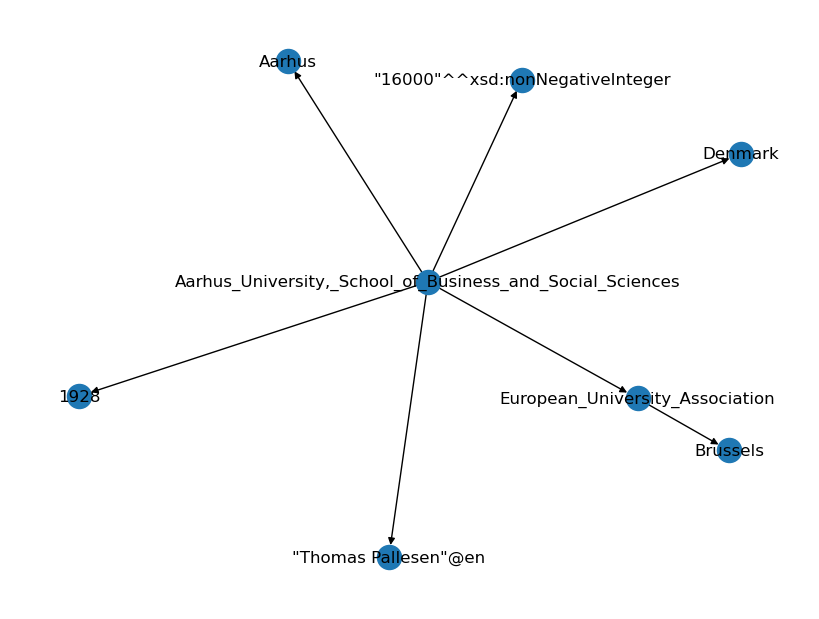

Decoded Input: 
 translate graph to text:  Aarhus_University,_School_of_Business_and_Social_Sciences  dean  "Thomas Pallesen"@en  Aarhus_University,_School_of_Business_and_Social_Sciences  city  Aarhus  Aarhus_University,_School_of_Business_and_Social_Sciences  numberOfStudents  "16000"xsd:nonNegativeInteger  European_University_Association  headquarters  Brussels  Aarhus_University,_School_of_Business_and_Social_Sciences  country  Denmark  Aarhus_University,_School_of_Business_and_Social_Sciences  affiliations  European_University_Association  Aarhus_University,_School_of_Business_and_Social_Sciences  established  1928
Decoded Target: 
 The city of Aarhus in Denmark is the location of the School of Business and Social Sciences at the Aarhus University which was established in 1928 and affiliated with the European University Association headquartered in Brussels. The current Dean is Thomas Pallesen and there are 16000 students.


Data(x=[512], edge_index=[2, 7], attention_mask=[512], y=[512])

In [26]:
# Print the postprocessed output for the first item in the dataset
dataset[-3]